In [1]:

from pathlib import Path
%load_ext autoreload
%autoreload 2

current_dir = Path().resolve() 
parent_dir = current_dir.parent    
results_dir = parent_dir / "results" 

from abcnre.inference import load_estimator_from_yaml

estimator = load_estimator_from_yaml(
    results_dir / "estimator" / "estimator.yaml",
)

simulator = estimator.simulator

INFO:abcnre.training.config:Loaded configuration from /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_classif_config.yaml
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/antoineluciano/.pyenv/versions/3.10.13/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/antoineluciano/.pyenv/vers

Computing epsilon for 100.0% quantile...
Setting epsilon to infinity (maximum distance).


INFO:abcnre.simulation.io:Summary network loaded and integrated into simulator
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for MLP network
INFO:abcnre.training.registry:Created MLP network (from 'MLP') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': False, 'dropout_rate': 0.0, 'hidden_dims': [64, 64, 64], 'output_dim': 1}
INFO:abcnre.inference.io:Loaded trained params and log ratio function from: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/estimator/estimator_classif_params.npz
INFO:abcnre.training.registry:Registered networks: MLP, DeepSet, ConditionedDeepSet
INFO:abcnre.training.registry:Set output_dim=1 for MLP network
INFO:abcnre.training.registry:Created MLP network (from 'MLP') for classifier
INFO:abcnre.training.registry:Network args: {'activation': 'relu', 'use_layer_norm': False, 'dropout_rate': 0.0,

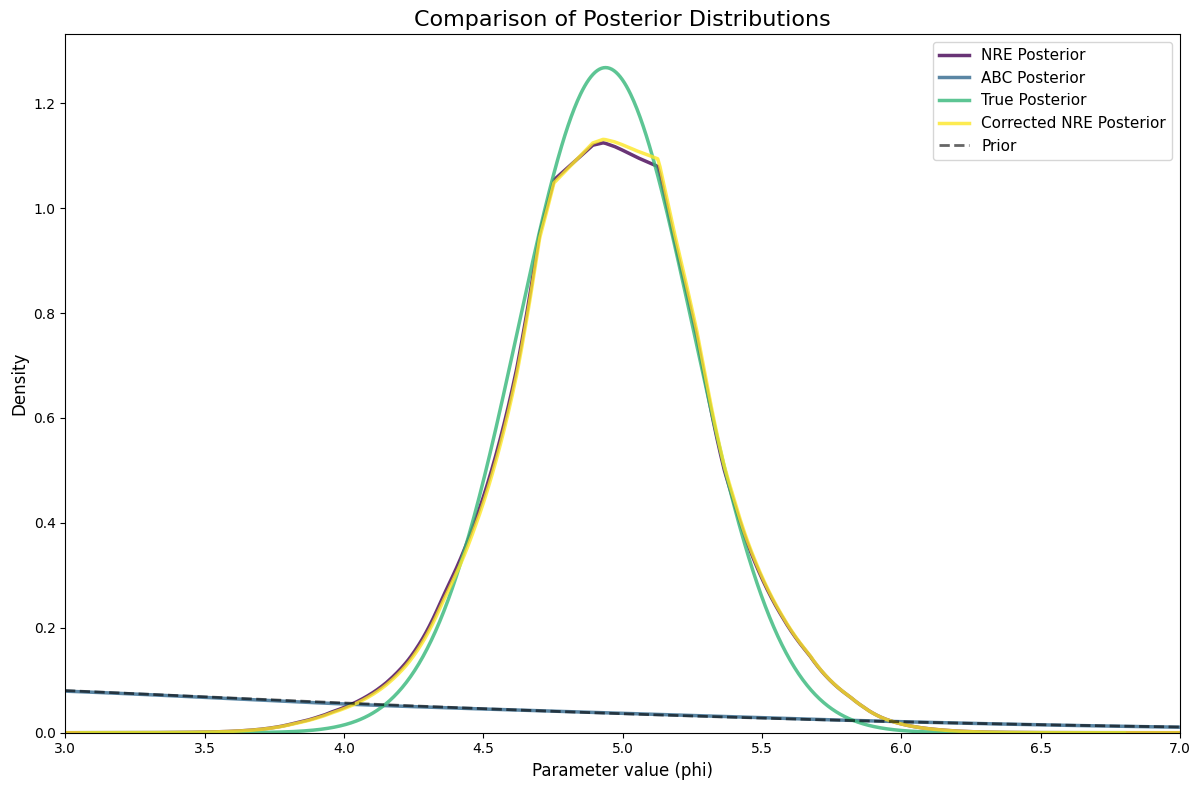


✅ Diagnostics complete.


In [2]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison
import numpy as np

abc_phi_samples = estimator.stored_phis
min_phi, max_phi = np.min(abc_phi_samples), np.max(abc_phi_samples)

n_grid = 10000  # Number of grid points for the posterior distribution
abc_phi_grid = np.linspace(min_phi, max_phi, n_grid)

# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(estimator)
phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, 
                                       initial_bounds=(min_phi, max_phi), 
                                        n_grid_points=n_grid)

# Get prior for plotting
prior_pdf_values = simulator.model.prior_phi_pdf(abc_phi_grid)

true_grid, true_pdf = get_normalized_pdf(simulator.model.get_posterior_phi_distribution(simulator.observed_data).pdf, initial_bounds=(min_phi, max_phi))

unnormalized_corrected_pdf_func = get_unnormalized_corrected_nre_pdf(estimator)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
                                    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
                                    initial_bounds=(min_phi, max_phi),
                                    n_grid_points=n_grid
)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
    initial_bounds=(min_phi, max_phi),
    n_grid_points=n_grid
)

# Generate the comparison plot - flatten ABC samples to 1D
plot_posterior_comparison(
    distributions={
        'NRE Posterior': (phi_grid, nre_pdf), 
        'ABC Posterior': abc_phi_samples.flatten(),  # Flatten to 1D array
        'True Posterior': (true_grid, true_pdf), 
        'Corrected NRE Posterior': (phi_corrected_grid, unnormalized_corrected_pdf)
    },
    prior_pdf=(abc_phi_grid, prior_pdf_values),
    xlim=(3,7)
    # save_path=output_dir / "posterior_comparison.png"
)

print("\n✅ Diagnostics complete.")


--- Step 7: Simulation-Based Calibration (SBC) ---
DEBUG: ABC-SBC sampled 10 data points. Type abc_results=<class 'abcnre.simulation.base.ABCSampleResult'>
DEBUG: ABC-SBC sampled 10 data points. Type abc_results=<class 'abcnre.simulation.base.ABCSampleResult'>


ABC-SBC Progress: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]



ABC-SBC complete.


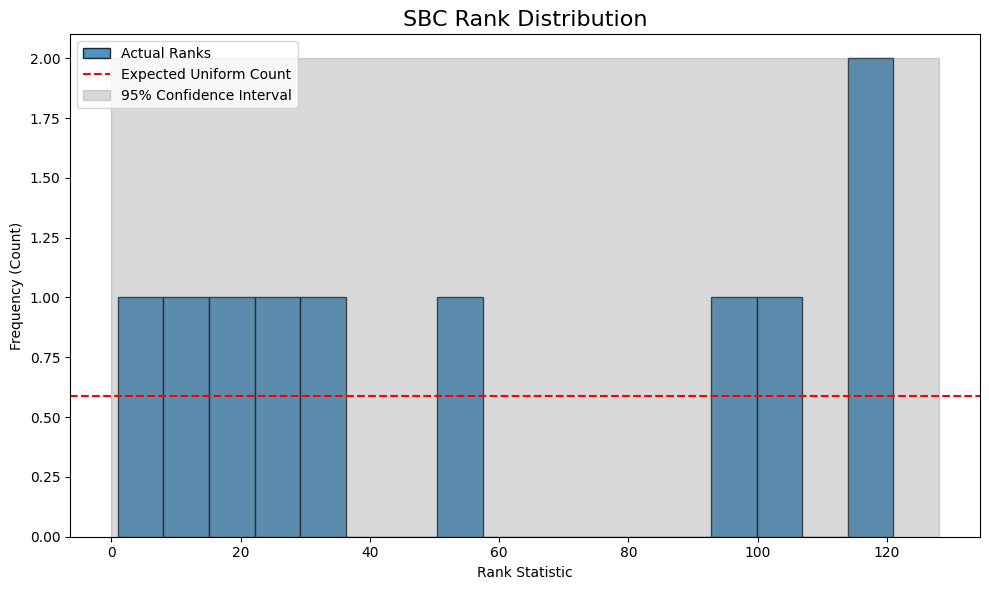

In [3]:
from abcnre.diagnostics.calibration import run_abc_sbc
from abcnre.diagnostics.viz import plot_sbc_ranks

# --- Step 7: Simulation-Based Calibration (SBC) ---
print("\n--- Step 7: Simulation-Based Calibration (SBC) ---")
import jax
key  = jax.random.PRNGKey(42)
num_posterior_samples = 128  
sbc_results = run_abc_sbc(
    key=key,
    estimator=estimator,
    num_sbc_rounds=10,
    num_posterior_samples=num_posterior_samples
)


plot_sbc_ranks(sbc_results)

In [5]:
print("\n--- Step 8: Creating Samplers and Running Metrics ---")
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unnormalized_corrected_nre_pdf, get_sampler_from_pdf
from abcnre.diagnostics.metrics import generate_and_evaluate_metrics, save_metrics_to_csv


# Define bounds for posterior calculation based on reference samples
min_phi = np.min(abc_phi_samples) - 1.0
max_phi = np.max(abc_phi_samples) + 1.0

# --- Create all necessary sampler functions ---
# A sampler is a function that takes (n_samples, key) and returns samples

unorm_nre_pdf = get_unnormalized_nre_pdf(estimator)
nre_sampler = get_sampler_from_pdf(
    unnormalized_pdf_func=unorm_nre_pdf,
    initial_bounds=(min_phi, max_phi)
)

unorm_corrected_nre_pdf = get_unnormalized_corrected_nre_pdf(
    estimator, phi_samples=abc_phi_samples
)
corrected_nre_sampler = get_sampler_from_pdf(
    unnormalized_pdf_func=unorm_corrected_nre_pdf,
    initial_bounds=(min_phi, max_phi)
)

true_sampler = simulator.get_true_posterior_samples

# abc_sampler = lambda: key, n_s:  simulator.get_abc_posterior_samples()

# --- Run the metrics suite ---
approx_samplers_dict = {
    "NRE_Standard": nre_sampler,
    "NRE_Corrected": corrected_nre_sampler,
    # "ABC": 
}

# The key here will be split inside the function for each sampler
key = jax.random.PRNGKey(123)
all_metrics_results = generate_and_evaluate_metrics(
    key=key,
    true_sampler=true_sampler,
    approx_samplers_dict=approx_samplers_dict,
    n_samples=5000
)

print("\n--- Quantitative Results ---")
save_metrics_to_csv(all_metrics_results, results_dir / "diagnostics_metrics.csv")


--- Step 8: Creating Samplers and Running Metrics ---
Generating 5000 samples for metrics evaluation...
Generating 5000 samples for metrics evaluation...
  -> Generating samples for 'NRE_Standard'...
  -> Generating samples for 'NRE_Standard'...
  -> Generating samples for 'NRE_Corrected'...
Running metrics suite...
  Computing metrics for 'NRE_Standard'...
  -> Generating samples for 'NRE_Corrected'...
Running metrics suite...
  Computing metrics for 'NRE_Standard'...
  Computing metrics for 'NRE_Corrected'...
  Computing metrics for 'NRE_Corrected'...
Metrics suite complete.

--- Quantitative Results ---
✅ Metrics for all methods saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/diagnostics_metrics.csv
Metrics suite complete.

--- Quantitative Results ---
✅ Metrics for all methods saved to /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_2D/results/diagnostics_metrics.csv
